# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

#### Terminology
<ul>
    <div style="text-align: justify"><li><b>Series:</b> A series is merely an ordered sequence of numbers. We might be using words that are chronological in nature (past, future, yet, already), but only because it makes it easer to understand. So forget about time, timestamps or intervals the property each data point has is the value and is its order: first, next, previous, last, etc.</li></div>
    <div style="text-align: justify"><li><b>Observed <i>vs</i> Expected:</b> Forecasting is estimating values that we do not yet know based on the previous values. The values we know are referred to as <b>observed</b> while the values we forecast as <b>expected</b>. The math convention to denote expected values is with the circumflex $\hat{y}$</li></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product 
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [3]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [4]:
mpl.rcParams['font.size'] = 15.0

In [5]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### Time Series Components 
<div style="text-align: justify">A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.</div>
<ul>
    <li><b>Systematic:</b> Components of the time series that have consistency or recurrence and can be described and modeled.</li>
    <li><b>Non-Systematic:</b> Components of the time series that cannot be directly modeled.</li>
</ul>
<div style="text-align: justify">A given time series is thought to consist of three systematic components including <b>level</b>, <b>trend</b>, <b>seasonality</b>, and one non-systematic component called <b>noise</b>.</div>
<ul>
    <li><b>Level:</b> The average value in the series.</li>
    <li><b>Trend:</b> The increasing or decreasing value in the series.</li>
    <li><b>Seasonality:</b> The repeating short-term cycle in the series.</li>
    <li><b>Noise:</b> The random variation in the series.

### <span style="color:red">Analysis of the last N days</span>

In [6]:
Ndays = '150days'

### <span style="color:red">Day range for matplotlib</span>

In [7]:
Ninterval = 7

In [8]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [9]:
#filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [10]:
df = pd.read_csv(url)
# df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [11]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['total_cases'], ascending=True)

# Number of cases and deaths in World

In [12]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld.tail(15)

,date,total_cases,total_deaths,new_cases,new_deaths
134,2020-08-20,22437439.0,787678.0,281318.0,6536.0
135,2020-08-21,22713577.0,794018.0,276138.0,6340.0
136,2020-08-22,22967271.0,799935.0,253694.0,5917.0
137,2020-08-23,23233832.0,805568.0,266561.0,5633.0
138,2020-08-24,23458349.0,808887.0,224517.0,3319.0
139,2020-08-25,23669713.0,813150.0,211364.0,4263.0
140,2020-08-26,23924888.0,819640.0,255175.0,6490.0
141,2020-08-27,24201407.0,825930.0,276519.0,6290.0
142,2020-08-28,24484671.0,832007.0,283264.0,6077.0
143,2020-08-29,24761382.0,837462.0,276711.0,5455.0


In [13]:
# scaler = MinMaxScaler()
# dfWorld[['total_cases', 'total_deaths', 'new_cases', 'new_deaths']] = scaler.fit_transform(dfWorld[['total_cases', 'total_deaths', 'new_cases', 'new_deaths']])

In [14]:
# dfWorld

In [15]:
ads = dfWorld.loc[:,['date','new_cases']]
ads = ads.set_index('date')

In [16]:
currency = dfWorld.loc[:,['date','new_deaths']]
currency = currency.set_index('date')

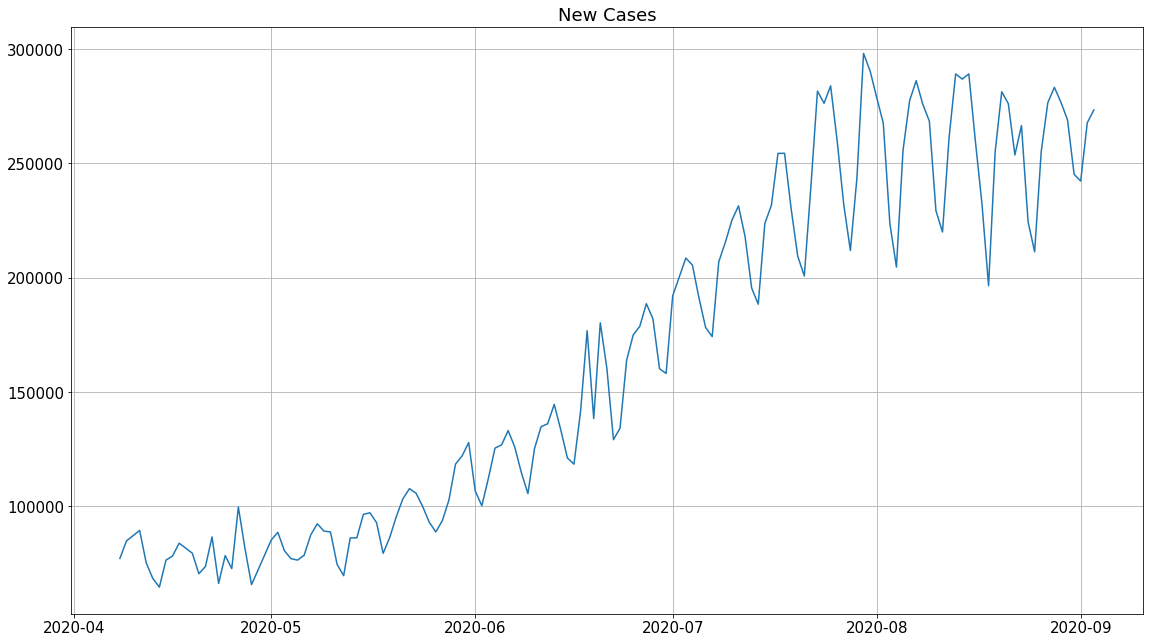

In [17]:
plt.figure(figsize=(19.20,10.80))
plt.plot(ads.new_cases)
plt.title('New Cases')
plt.grid(True)
plt.show()

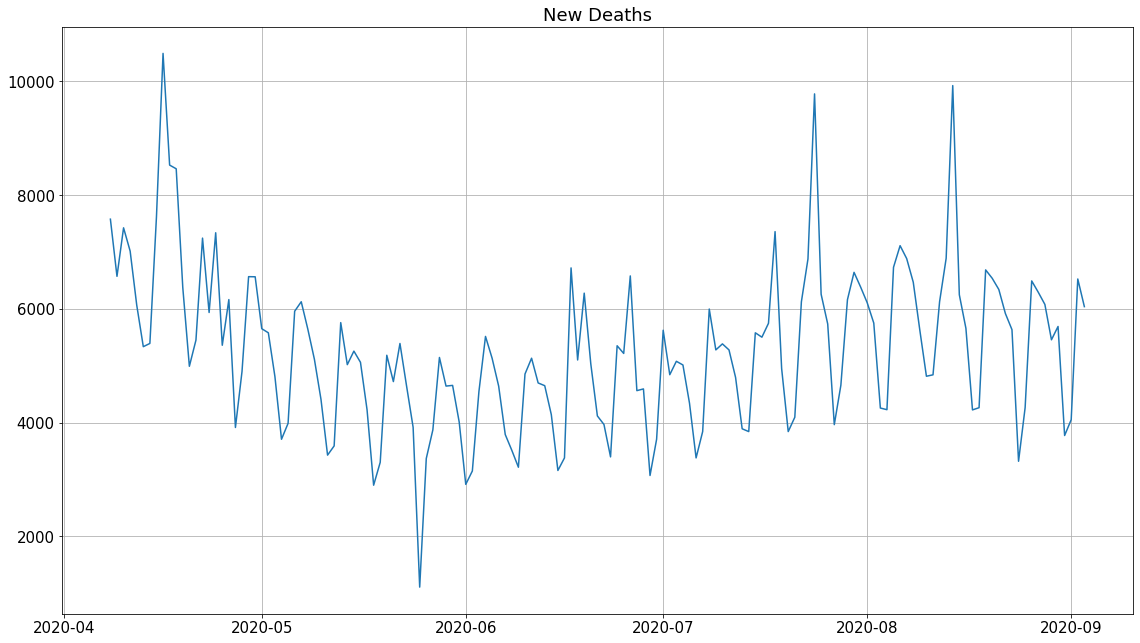

In [18]:
plt.figure(figsize=(19.20,10.80))
plt.plot(currency.new_deaths)
plt.title('New Deaths')
plt.grid(True)
plt.show()

#### Mean Absolute Error (MAE)
<div style="text-align: justify">MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.</div>
<br>
<div style="font-size:20px"><center>$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$</center></div>
<br>
<div style="text-align: justify">where, $\hat{y}_i$ is the predicted value of the <i>i</i>-th sample, $y_i$ is the corresponding true value and <i>n</i> is the number of samples.</div>

#### Mean Absolute Percentage Error (MAPE)
<div style="text-align: justify">MAPE measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error.</div>
<br>
<div style="font-size:20px"><center>$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$</center></div>

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Moving Average
<div style="text-align: justify">The future value $\hat{y}_i$ of our variable depends on the average of its <i>k</i> previous values.
<div style="font-size:20px"><center>$\hat{y}_{i} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{i-n}$</center></div>

In [20]:
def moving_average(series, n):
    return np.average(series[-n:])

In [21]:
moving_average(ads, 7)

265379.71428571426

In [22]:
moving_average(currency, 7)

5372.142857142857

In [23]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(19.20, 10.80))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

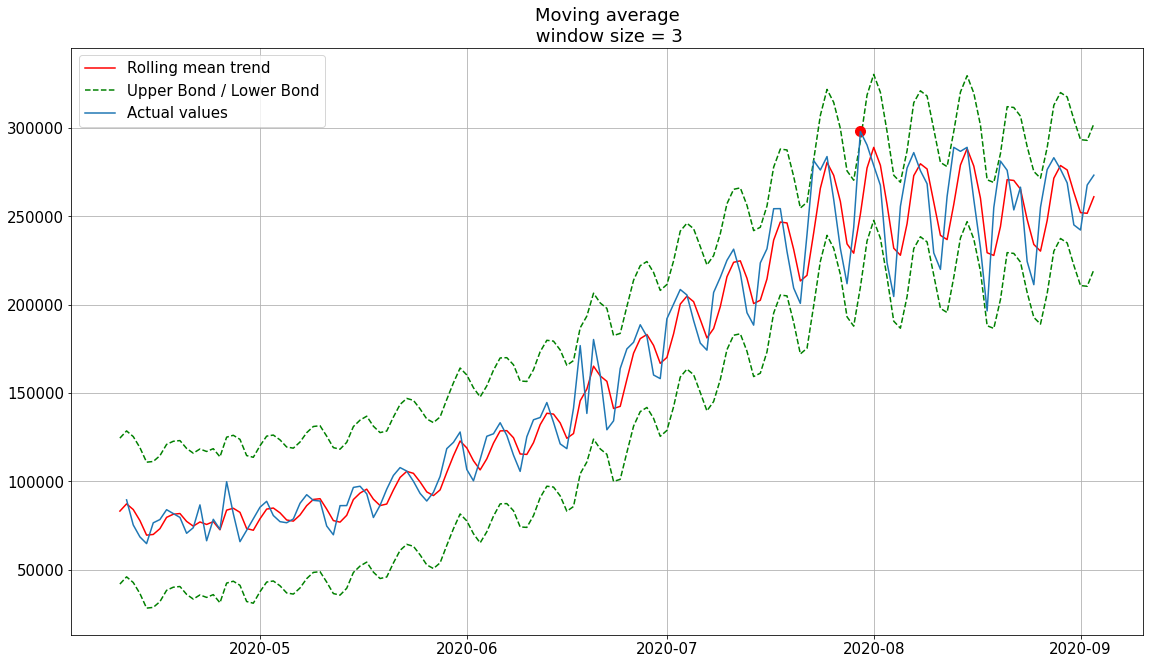

In [24]:
plotMovingAverage(ads, 3, plot_intervals=True, plot_anomalies=True)

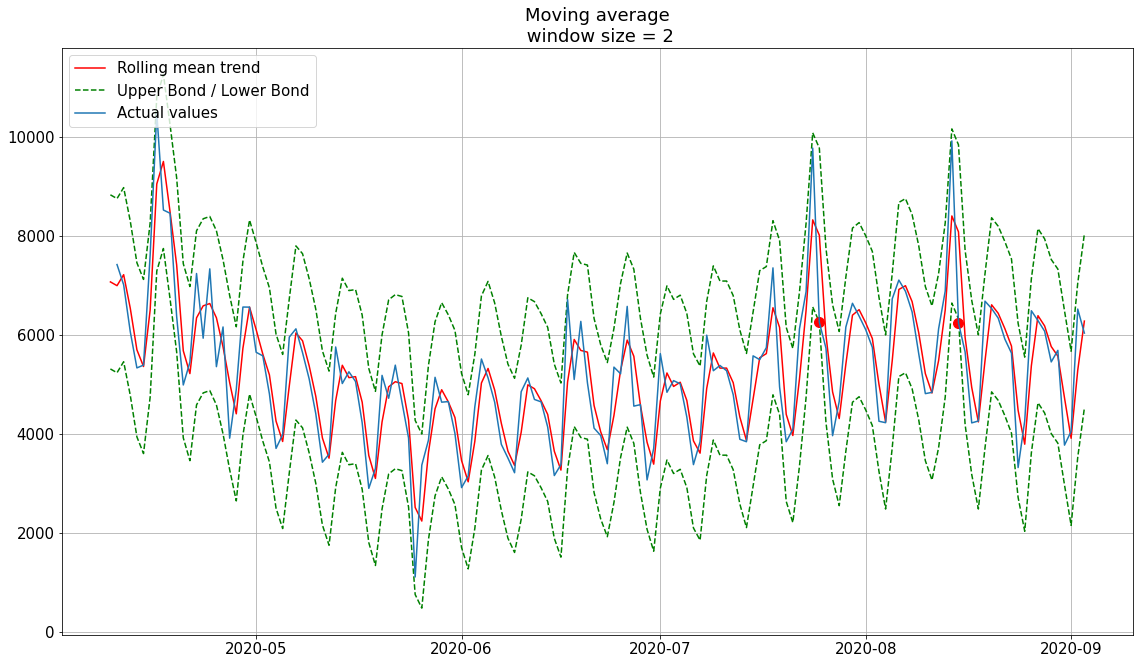

In [25]:
plotMovingAverage(currency, 2, plot_intervals=True, plot_anomalies=True)

#### Weighted Average
<div style="text-align: justify">A weighted average is the average of a data set that recognizes certain numbers as more important than others. In calculating a weighted average, each number in the data set is multiplied by a predetermined weight before the final calculation is made.
A weighted average can be more accurate than a simple average in which all numbers in a data set are assigned an identical weight.</div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$</center>

In [26]:
def weighted_average(series, weights):
    result = 0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [27]:
weighted_average(ads, [0.6, 0.3, 0.1])

253053.69999999998

#### Exponential Smoothing
<div style="text-align: justify">Exponential Smoothing assigns exponentially decreasing weights as the observation get older.In other words, recent observations are given relatively more weight in forecasting than the older observations.</div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$</center>

In [28]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return result

In [29]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(19.20,10.80))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
            
        plt.plot(series.values, 'b--', label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

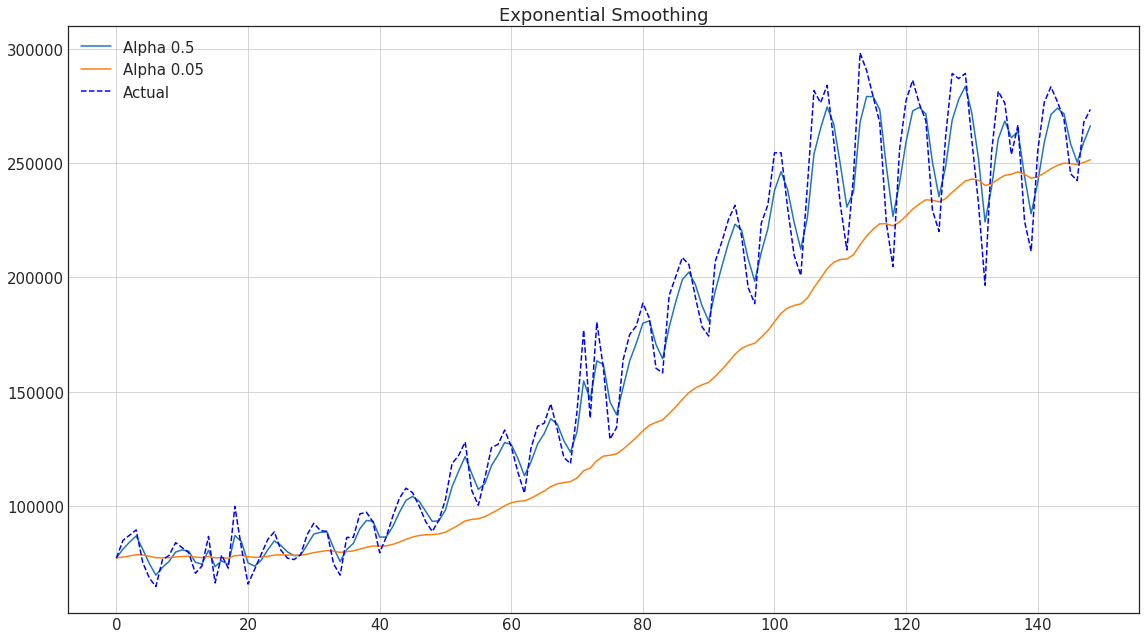

In [30]:
plotExponentialSmoothing(ads.new_cases, [0.5, 0.05])

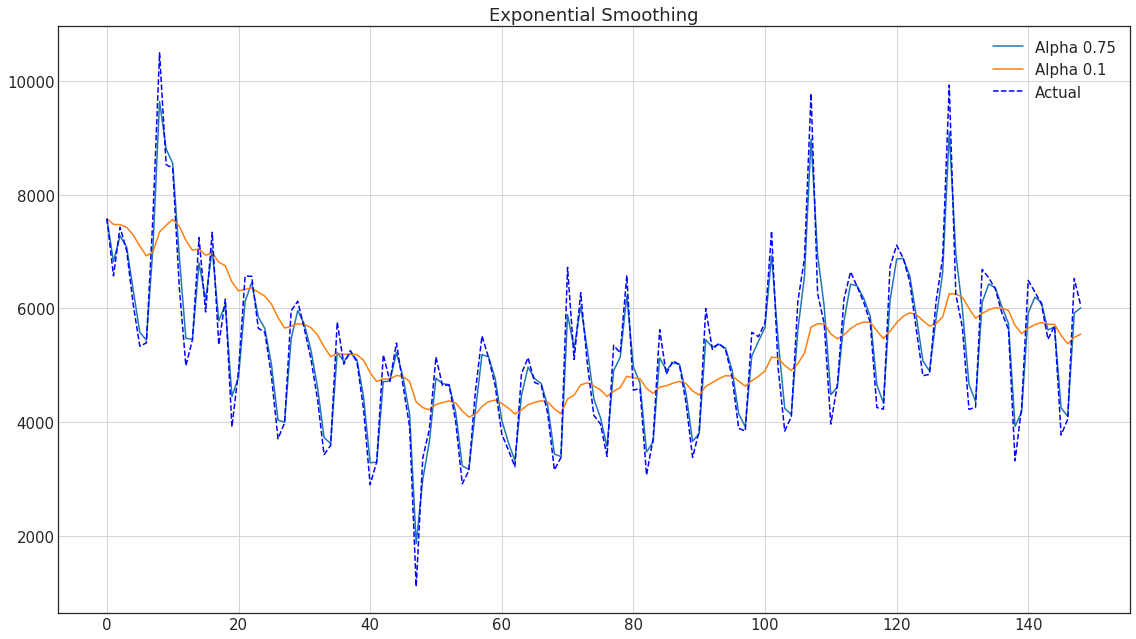

In [31]:
plotExponentialSmoothing(currency.new_deaths, [0.75, 0.1])

#### Double exponential smoothing

### Exponential Smoothing
<div style="text-align: justify">Simple exponential smoothing does not do well when there is a trend in the data.</div>
<div style="text-align: justify">Use Double Exponential Smoothing as a general smoothing method and to provide short-term forecasts when your data have a trend and do not have a seasonal component. This procedure calculates dynamic estimates for two components: level and trend.</div>
<br>
<div style="font-size:20px"><center>$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$</center></div>
<br>
<div style="font-size:20px"><center>$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$</center></div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{x+1} = \ell_x + b_x$</center></div>
<br>
<div style="text-align: justify">where, $\ell_x$ is the level, $b_x$ is the trend, and $\beta$ coefficiente is a weight for exponential smoothing.</div>
<div style="text-align: justify">The <b>first equation</b> describes the level, where, the second term is now split into previous values of the level and of the trend.</div> 
<div style="text-align: justify">The <b>second equation</b> describes the trend, which depends on the level changes at the current step and on the previous value of the trend. The <b>final prediction</b> is the sum of the model values of the level and trend.</div>

In [32]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        
        if n >= len(series):
            value = result[-1]
        
        else:
            value = series[n]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [33]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(19.20,10.80))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta),
                         label='Alpha {}, Beta {}'.format(alpha,beta))
                plt.plot(series.values, label='Actual')
                plt.legend(loc='best')
                plt.axis('tight')
                plt.title('Double Exponential Smoothing')
                plt.grid(True)

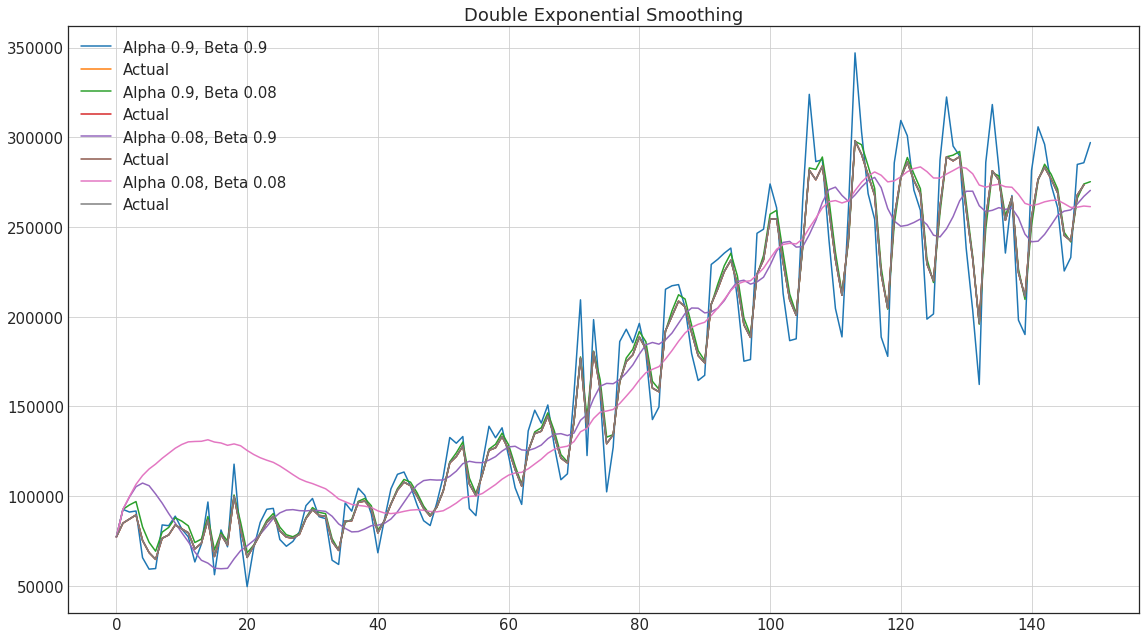

In [34]:
plotDoubleExponentialSmoothing(ads.new_cases, alphas=[0.9, 0.08], betas=[0.9, 0.08])

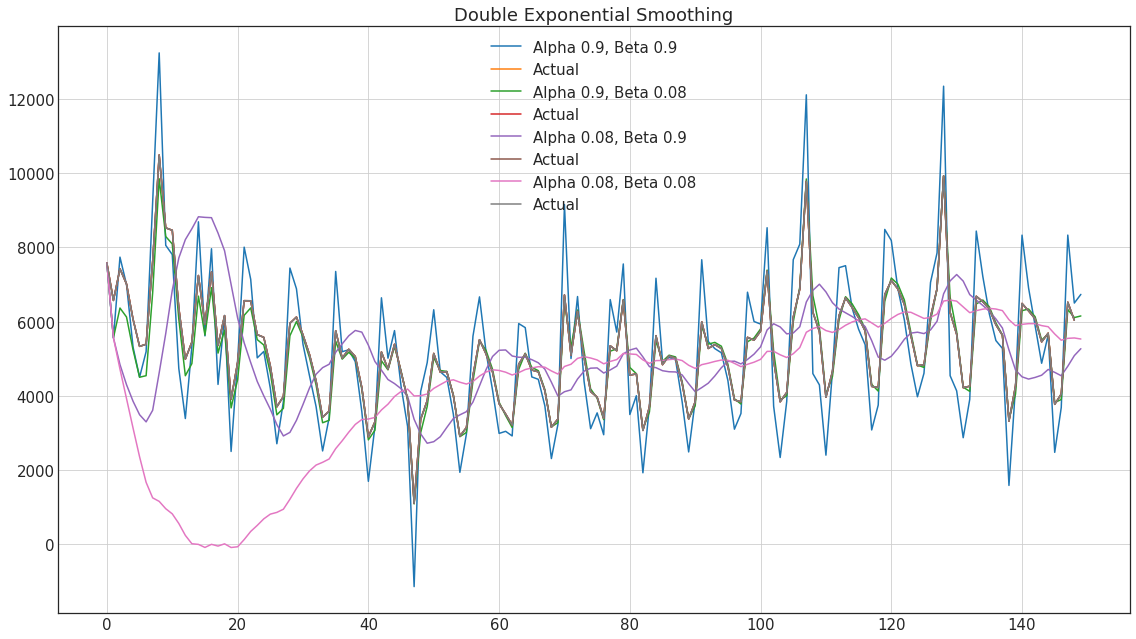

In [35]:
plotDoubleExponentialSmoothing(currency.new_deaths, alphas=[0.9, 0.08], betas=[0.9, 0.08])

#### Triple Exponential Smoothing
<div style="text-align: justify">Also known as the Holt-Winters method. The idea is to add a third component - <b>seasonality</b>.</div>
<div style="text-align: justify">Seasonal components in the model will explain repeated variations around level and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat.</div>


<br>
<div style="font-size:20px"><center>$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$</center></div>
<br>
<div style="font-size:20px"><center>$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$</center></div>
<br>
<div style="font-size:20px"><center>$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$</center></div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$</center></div>

In [36]:
class HoltWinters:
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [37]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, alpha=alpha,
                           beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
    
    return np.mean(np.array(errors))

In [38]:
%%time
data = currency.new_deaths[:-20]
x = [0, 0, 0]

opt = minimize(timeseriesCVscore, x0=x,
               args=(data, mean_squared_log_error),
               method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen=7, alpha=alpha_final,
                   beta=beta_final, gamma=gamma_final,
                   n_preds=50, scaling_factor=3)

model.triple_exponential_smoothing()

0.26570610586840226 0.05631337015906185 0.8073017456491312
CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.09 s


In [39]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    plt.figure(figsize=(19.20,10.80))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
        series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
        series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

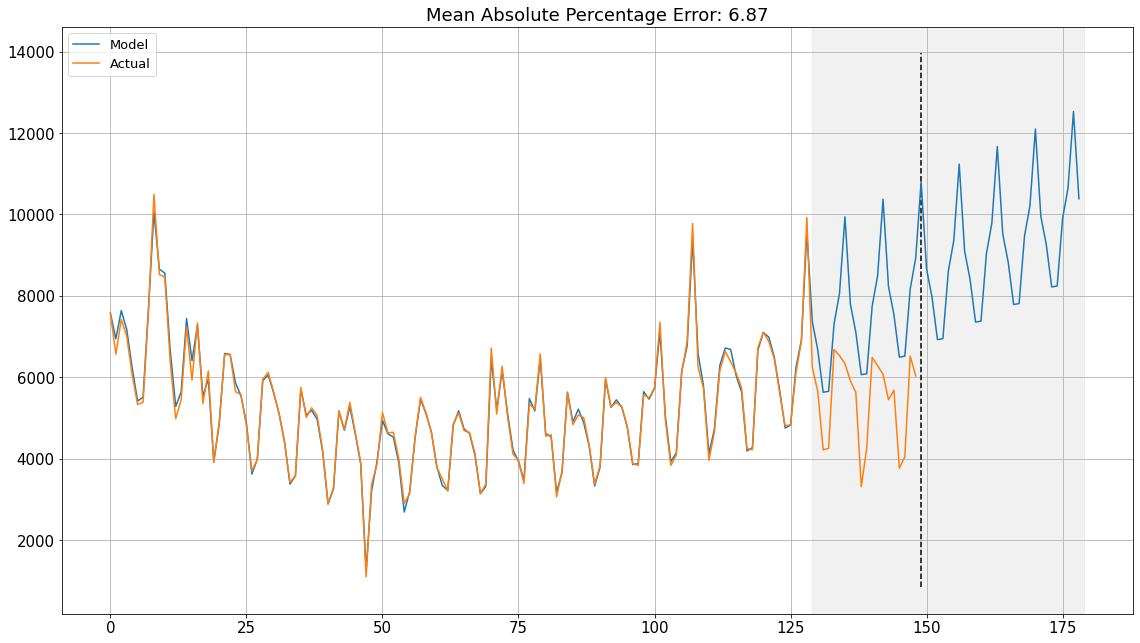

In [40]:
plotHoltWinters(currency.new_deaths)

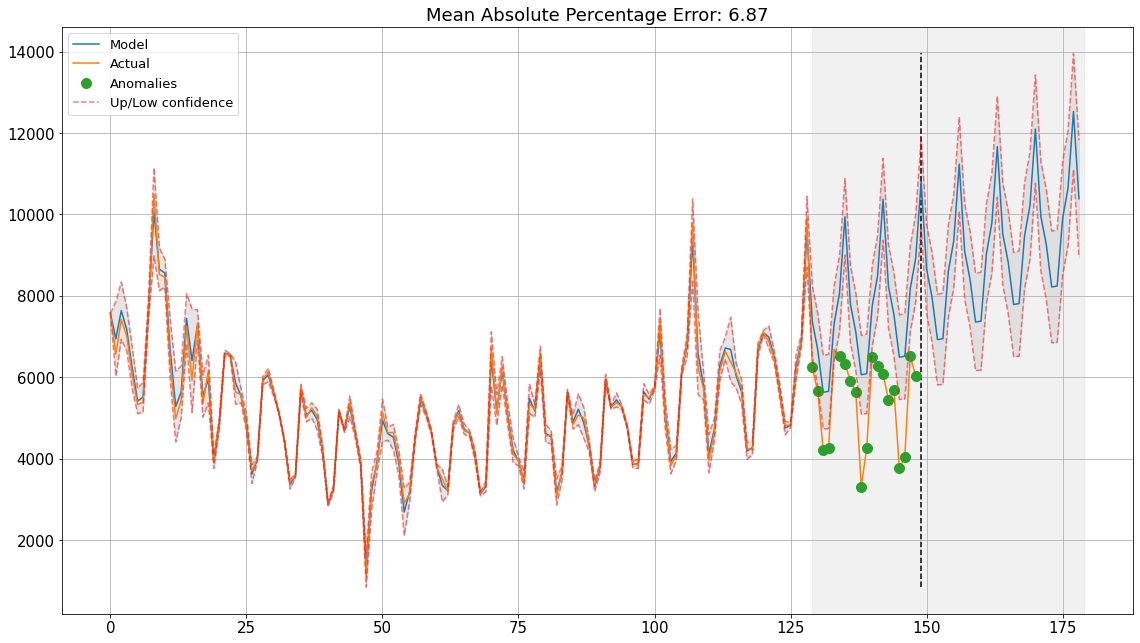

In [41]:
plotHoltWinters(currency.new_deaths, plot_intervals=True, plot_anomalies=True)

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

#### Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python